# Libraries and data importing

Importing packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

Importing data

In [3]:
activities = pd.read_parquet('../data-raw/activities.parquet')
activities

,contributor,category,repository,activity,date
0,AmplabJenkins,bot,apache/spark,Commenting pull request,2022-11-25 09:55:19+00:00
1,AmplabJenkins,bot,apache/spark,Commenting pull request,2022-11-25 09:55:23+00:00
2,AmplabJenkins,bot,apache/spark,Commenting pull request,2022-11-25 09:55:26+00:00
3,analysis-bot,bot,facebook/react-native,Commenting pull request,2022-11-25 09:55:27+00:00
4,neos-bot,bot,neos/neos-ui-compiled,Pushing commits,2022-11-25 09:55:47+00:00
...,...,...,...,...,...
1015418,798388,human,879434,Reviewing code,2023-04-15 16:06:15+00:00
1015419,798388,human,879434,Reviewing code,2023-04-15 16:07:26+00:00
1015420,784775,human,643744,Creating branch,2023-04-15 16:07:33+00:00
1015421,784775,human,888378,Opening pull request,2023-04-15 16:08:07+00:00


Calculating the date 3 months ago from the last date in the data and filters the dataframe to include only the rows with dates greater than or equal to the date 3 months ago

In [4]:
thresholded_activities = (
    activities[activities['date'] >= activities['date'].max() - pd.DateOffset(months=3)]
    .groupby('contributor')
    .tail(300)
    .groupby(['category', pd.Grouper(key='date', freq='H'), 'contributor'])['activity']
    .count()
    .reset_index(name='n_activities')
    # keep data for contributors who have more than 10 different hour sequences
    .groupby('contributor')
    .filter(lambda x: len(x) >= 10)
)
thresholded_activities

,category,date,contributor,n_activities
0,bot,2023-01-15 16:00:00+00:00,AmplabJenkins,1
1,bot,2023-01-15 17:00:00+00:00,apollo-cla,1
2,bot,2023-01-15 17:00:00+00:00,stickler-ci[bot],1
3,bot,2023-01-15 18:00:00+00:00,AmplabJenkins,2
5,bot,2023-01-15 18:00:00+00:00,mysql-oca-bot,1
...,...,...,...,...
53322,human,2023-04-15 15:00:00+00:00,947579,6
53323,human,2023-04-15 16:00:00+00:00,387854,2
53324,human,2023-04-15 16:00:00+00:00,668373,1
53325,human,2023-04-15 16:00:00+00:00,784775,4


Filling n_activities with zeros for the empty hours between the minimum and maximum date for each contributor, and sets the category and contributor columns to a default values 

In [5]:
data = (
    thresholded_activities
    .groupby(['category','contributor'])
    .apply(
        lambda x: x
        .set_index('date')
        # resample data to fill in missing hours with zeros
        .resample('H')
        .sum()
        .fillna(0)
        .reset_index()
        # set the 'category' and 'contributor' columns to the values of the data group
        .assign(category=lambda y: y.iloc[0]['category'], contributor=lambda y: y.iloc[0]['contributor'])
        )
    .set_index('date')
    .rename_axis(None)
)
data

,category,contributor,n_activities
2023-01-18 10:00:00+00:00,bot,0crat,1
2023-01-18 11:00:00+00:00,bot,0crat,12
2023-01-18 12:00:00+00:00,bot,0crat,3
2023-01-18 13:00:00+00:00,bot,0crat,6
2023-01-18 14:00:00+00:00,bot,0crat,2
...,...,...,...
2023-04-06 05:00:00+00:00,human,999769,0
2023-04-06 06:00:00+00:00,human,999769,0
2023-04-06 07:00:00+00:00,human,999769,2
2023-04-06 08:00:00+00:00,human,999769,0


In [ ]:
data[data['contributor'] == 'pytorchbot']

# Autocorrelation function

In [7]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

The optimal numer of lags is : 24


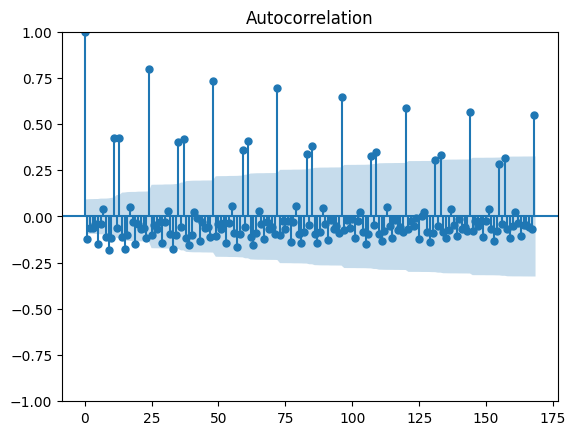

In [19]:
temp = data[data['contributor'] == 'pytorchbot']
lags = min(int((len(temp)/2)-1),168)

acf_values, _ = acf(temp['n_activities'].values, nlags=lags, alpha=0.05)

print('The optimal numer of lags is :', np.argmax(acf_values[1:])+1)

# Plot the autocorrelation function
plot_acf(temp['n_activities'].values, lags=lags)
plt.show()

The optimal numer of lags is : 168


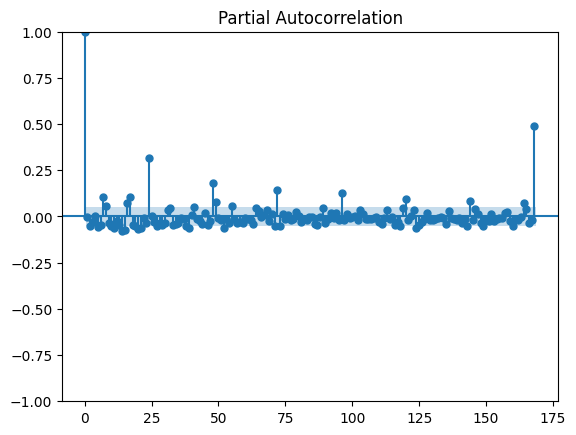

In [17]:
temp = data[data['contributor'] == 'lingohub[bot]']
lags = min(int((len(temp)/2)-1),168)

acf_values, _ = pacf(temp['n_activities'].values, nlags=lags, alpha=0.05, method='ols')

print('The optimal numer of lags is :', np.argmax(acf_values[1:])+1)

# Plot the partial autocorrelation function
plot_pacf(temp['n_activities'].values, lags=lags)
plt.show()

# 1. Autoregressive model

In [10]:
from statsmodels.tsa.ar_model import AutoReg

Partial autocorrelation is a commonly used tool for identifying the order of an autoregressive model.

In [11]:
def ar_model(contributor):

    # Spliting the data into training and testing sets for time series forecasting, using a time-based split with split size = 0.9
    train, test = (
        contributor.apply(lambda x: x[:int(0.9*len(x))]),
        contributor.apply(lambda x: x[int(0.9*len(x)):])
    )

    # Set the frequency of the index to hourly
    train.index.freq = 'H'

    # Choose the optimal number of lags
    lags = min(int((len(train)/2)-1),24*7)
    acf_values, _ = pacf(train['n_activities'].values, nlags=lags, alpha=0.05, method='ols')
    optimal_lags = np.argmax(acf_values[1:])+1

    # Fit the model
    model = AutoReg(train['n_activities'], lags=optimal_lags).fit()

    # Forecast the test set
    predictions = model.predict(start=len(train), end=len(train)+len(test)-1)

    # Create a series for evaluation metrics and sum of activities
    metrics = pd.Series({
        'contributor': contributor['contributor'].iloc[0],
        'category': contributor['category'].iloc[0],
        'r2': r2_score(test['n_activities'], predictions),
        'mae': mean_absolute_error(test['n_activities'], predictions),
        'mse': mean_squared_error(test['n_activities'], predictions),
        'n_activities': contributor['n_activities'].sum(),
        'optimal_lags': optimal_lags
    })

    return metrics


In [ ]:
# Apply the function to each contributor
ar_results = data.groupby(['category', 'contributor']).apply(ar_model).reset_index(drop=True)

In [13]:
ar_results.sort_values(by='r2', ascending=False).head(40)

,contributor,category,r2,mae,mse,n_activities,optimal_lags
181,octokit-fixture-user-a,bot,1.000000,6.729388e-15,8.522137e-29,300,24
203,pxw-bot,bot,0.998320,1.279474e-02,2.706766e-04,180,24
7,Code-Inside-Bot,bot,0.996353,3.698264e-02,1.942693e-02,300,24
84,dontcallmedom-bot,bot,0.968765,2.368231e-01,3.268458e-01,300,24
204,pytorchbot,bot,0.846771,3.147262e-01,3.296136e-01,300,24
32,angular-automatic-lock-bot[bot],bot,0.835230,5.865631e-01,4.514140e+00,300,24
47,ballerina-bot,bot,0.653284,8.266978e-01,1.251427e+00,300,24
259,usercont-release-bot,bot,0.608109,1.355249e+00,9.784332e+00,300,24
11,FlexGet-Bot,bot,0.424148,1.019979e-01,1.751234e-01,107,168
151,lingohub[bot],bot,0.406868,1.791989e-01,3.152722e-01,300,168


In [14]:
ar_results.to_csv('../eval-rest/ar_model_metrics.csv', index=False)

# 2. Moving-average model

In [24]:
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
def ma_model(contributor):

    print(contributor['contributor'].iloc[0])

    # Spliting the data into training and testing sets for time series forecasting, using a time-based split with split size = 0.9
    train, test = (
        contributor.apply(lambda x: x[:int(0.9*len(x))]),
        contributor.apply(lambda x: x[int(0.9*len(x)):])
    )

    # Set the frequency of the index to hourly
    train.index.freq = 'H'

    # Choose the optimal number of lags
    lags = min(int((len(train)/2)-1),24*7)
    acf_values, _ = acf(temp['n_activities'].values, nlags=lags, alpha=0.05)
    optimal_lags = np.argmax(acf_values[1:])+1

    # Fit the model
    model = ARIMA(train['n_activities'], order=(0, 0, optimal_lags)).fit()

    # Forecast the test set
    predictions = model.forecast(steps=len(test))

    # Create a series for evaluation metrics and sum of activities
    metrics = pd.Series({
        'contributor': contributor['contributor'].iloc[0],
        'category': contributor['category'].iloc[0],
        'r2': r2_score(test['n_activities'], predictions),
        'mae': mean_absolute_error(test['n_activities'], predictions),
        'mse': mean_squared_error(test['n_activities'], predictions),
        'n_activities': contributor['n_activities'].sum(),
        'optimal_lags': optimal_lags
    })

    return metrics

In [ ]:
# Apply the function to each contributor
ma_results = data.groupby(['category', 'contributor']).apply(ma_model).reset_index(drop=True)

In [22]:
ma_results.sort_values(by='r2', ascending=False).head(40)

,contributor,category,r2,mae,mse,n_activities,optimal_lags
117,google-oss-bot,bot,0.714341,3.156574,13.887989,300,24
259,usercont-release-bot,bot,0.417529,1.698670,14.542510,300,24
47,ballerina-bot,bot,0.400089,1.163808,2.165304,300,24
32,angular-automatic-lock-bot[bot],bot,0.374141,1.666410,17.146444,300,24
84,dontcallmedom-bot,bot,0.300728,1.241525,7.317192,300,24
15,ININ-TransifexAutomation,bot,0.252032,0.027499,0.030066,22,24
204,pytorchbot,bot,0.247487,0.771356,1.618739,300,24
7,Code-Inside-Bot,bot,0.246173,0.789493,4.015277,300,24
181,octokit-fixture-user-a,bot,0.243720,0.646273,3.102290,300,24
261,vc-ci,bot,0.156228,1.847594,9.432164,300,24


In [ ]:
ma_results.to_csv('../eval-rest/ma_model_metrics.csv', index=False)

# 3. Autoregressive Moving-average model

In [39]:
def arma_model(contributor):

    print(contributor['contributor'].iloc[0])

    # Spliting the data into training and testing sets for time series forecasting, using a time-based split with split size = 0.9
    train, test = (
        contributor.apply(lambda x: x[:int(0.9*len(x))]),
        contributor.apply(lambda x: x[int(0.9*len(x)):])
    )

    # Set the frequency of the index to hourly
    train.index.freq = 'H'

    # Choose the optimal parameters
    lags = min(int((len(train)/2)-1),24*7)

    pacf_values, _ = pacf(temp['n_activities'].values, nlags=lags, alpha=0.05)
    p = np.argmax(pacf_values[1:])+1

    acf_values, _ = acf(temp['n_activities'].values, nlags=lags, alpha=0.05)
    q = np.argmax(acf_values[1:])+1

    print (p, q)

    # Fit the model
    model = ARIMA(train['n_activities'], order=(p, 0, q), seasonal_order=(0, 0, 0, 24), trend="c").fit(method='yule_walker')

    # Forecast the test set
    predictions = model.forecast(steps=len(test))

    # Create a series for evaluation metrics and sum of activities
    metrics = pd.Series({
        'contributor': contributor['contributor'].iloc[0],
        'category': contributor['category'].iloc[0],
        'r2': r2_score(test['n_activities'], predictions),
        'mae': mean_absolute_error(test['n_activities'], predictions),
        'mse': mean_squared_error(test['n_activities'], predictions),
        'n_activities': contributor['n_activities'].sum(),
        'p_order': p,
        'q_order': q
    })

    return print(metrics)

arma_model(data[data['contributor'] == 'lingohub[bot]'])

lingohub[bot]
165 24


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


KeyboardInterrupt: 

In [ ]:
contributor = data[data['contributor'] == 'pytorchbot']

train, test = (
    contributor.apply(lambda x: x[:int(0.9*len(x))]),
    contributor.apply(lambda x: x[int(0.9*len(x)):])
)

# Set the frequency of the index to hourly
train.index.freq = 'H'

In [ ]:
lags = min(int((len(train)/2)-1),24*7)
acf_values, _ = acf(temp['n_activities'].values, nlags=lags, alpha=0.05)
optimal_lags = np.argmax(acf_values[1:])+1

In [ ]:
# Fit the model
model = ARIMA(train['n_activities'], order=(0, 0, optimal_lags)).fit()
predictions = model.forecast(steps=len(test))

In [ ]:
# Evaluate the model
r2 = r2_score(test['n_activities'], predictions)
mse = mean_squared_error(test['n_activities'], predictions)
mae = mean_absolute_error(test['n_activities'], predictions)

print(f'R-squared: {r2:.2f}')
print(f'MSE: {mse:.2f}')
print(f'MAE: {mae:.2f}')

# 4. Autoregressive integrated Moving-average model

# 5. Seasonal Autoregressive integrated Moving-average with eXogenous regressors model

# 6. Vector Autoregressive model

# 7. Vector Autoregressive Moving-average with eXogenous regressors model

# 8. Unobserved components model

# 9. Dynamic factor models

# 10. Simple exponential smoothing

# 11. Holt’s linear exponential smoothing

# 12. Holt-Winters exponential smoothing